# Subsampling approaches to MCMC for tall data

Last modified on 11th May 2015

This notebook illustrates various approaches to subsampling MCMC, see (Bardenet, Doucet, and Holmes, ICML'14 and a 2015 arxiv preprint entitled "On MCMC for tall data" by the same authors. By default, executing cells from top to bottom will reproduce the running examples in the latter paper. If you want to jump to a particular method, you should at least evaluate the first two sections beforehand ("Generate..." and "Vanilla MH"), as they contain functions and data that is used throughout the notebook. Please report any issue (or interesting discovery!) to the paper's corresponding author.

**Table of contents**    
[Generate toy data](#Generate-toy-data)  
[Vanilla MH](#Vanilla-isotropic-Gaussian-random-walk-Metropolis)  
[Informed subsampling](#ISS-MCMC)
[Confidence sampler without proxy](#Vanilla-confidence-sampler)  
[Confidence sampler with proxy](#Confidence-MH-with-2nd-order-Taylor-likelihood-proxy)  


In [2]:
%pylab inline
figsize(10,10) # in the global namespace when inline backend is in use.

Populating the interactive namespace from numpy and matplotlib


In [3]:
from algorithms.confidence_ss import confidenceMCMC 
from algorithms.confidence_ss import confidenceMCMCWithProxy
from algorithms.confidence_ss import confidenceMCMCWithProxyDroppedAlong
from algorithms.iss import iss_mcmc
from algorithms.vanillaMH import vanillaMH

sns.set(style="ticks");

plt.ioff() # turn off interactive plotting
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
mpl.rcParams['xtick.labelsize'] = 22
mpl.rcParams['ytick.labelsize'] = 22
plt.rc('axes', labelsize=22)
plt.rc('legend', fontsize=22)
mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True
npr.seed(1)

We will save Figures in the following directory, by default it is the current directory.

In [4]:
saveDirStr = "figs"

## Generate toy data

First, let us generate some data. Change variable "dataType" to switch between the Gaussian and the lognormal examples from the paper. 

In [5]:
# Generate data
npr.seed(1)
N = 100000
# Here is where we make the model mis-specified
dataType = "Gaussian"
if dataType == "Gaussian":
    x = npr.randn(N)
elif dataType == "logNormal":
    x = npr.lognormal(0,1,size=N)
elif dataType == "laplace":
    x = npr.laplace(0,math.pow(0.5,0.5),size=N)

# We store the mean and std deviation for later reference, they are also the MAP and MLE estimates in this case.
realMean = np.mean(x)
realStd = np.std(x)
print("Mean of x =", realMean)
print("Std of x =", realStd)

# Where we will start all theta chains
initial_theta = np.array([realMean,np.log(realStd)])

Mean of x = -0.003482840286949395
Std of x = 1.0028484705532725


In [112]:
plt.clf()
plt.hist(x, 30, normed=True)
plt.show()

We are going to estimate the mean and std deviation of a Gaussian model, applied to the toy dataset generated above.

In [45]:
def getLogLhd(x, mu, sigma):
    """
    return an array of Gaussian log likelihoods up to a constant
    """
    return -(x-mu)**2/(2*sigma**2) - np.log(sigma)

In [121]:
def error(ref_chain,evaluated_chain):
    '''
    Given two one dimensional chains - this function evaluates the area difference in the histograms
    '''
    ref_values, ref_bins, _ = plt.hist(ref_chain, normed=True)
    alg_values, _, _ = plt.hist(evaluated_chain, bins=ref_bins, normed=True)
    alg_error = np.sum(numpy.diff(ref_bins)*abs(ref_values - alg_values)) 
    return alg_error

In [ ]:
def latest_errors():
    mean_error = error(S_ref[:,0],S[:,0])
    std_error = error(S_ref[:,1],S[:,1])
    return (mean_error, std_error)

The following function plots the results as in the paper. It is a bit messy, but you can safely skip this cell without missing anything on the algorithms.

In [46]:
def plotResults(S, ns, algoName="doesNotMatter", weights="doesNotMatter", boolSave=0, figId="basic"):
    """
    plot results
    """    
    # Plot joint sample with seaborn
    m = np.min(S[:,0]) # Precompute limits for x and y plots
    M = np.max(S[:,0])
    m_ref = np.min(S_ref[:,0]) # Precompute limits for x and y plots
    M_ref = np.max(S_ref[:,0])
    
    xlimInf = min(m, m_ref)# - (M-m)/10
    xlimSup = max(M, M_ref)# +(M-m)/10
    print("xlims =", xlimInf, xlimSup) # +(M-m)/10
    xPlot = np.linspace(xlimInf, xlimSup, 1000)
    m = np.min(np.exp(S[:,1]))
    M = np.max(np.exp(S[:,1]))
    m_ref = np.min(np.exp(S_ref[:,1])) # Precompute limits for x and y plots
    M_ref = np.max(np.exp(S_ref[:,1]))
    ylimInf = min(m, m_ref)# - (M-m)/10
    ylimSup = max(M, M_ref)
    yPlot = np.linspace(ylimInf, ylimSup, 1000)
    
    g = sns.jointplot(S[:,0], np.exp(S[:,1]), kind="hex", space=0,size=10, xlim=(xlimInf,xlimSup), ylim=(ylimInf,ylimSup), stat_func=None, marginal_kws={"norm_hist":True}) # 
    plt.sca(g.ax_joint)
    plt.xlabel("$\mu$",)
    plt.ylabel("$\sigma$")
    
    # Add Reference long MH draw 
    # ... to the joint plot
    sns.kdeplot(S_ref[:,0], np.exp(S_ref[:,1]), ax=g.ax_joint, bw="silverman", cmap="BuGn_r", linewidth=5)
    # ... to the marginal plots
    g.ax_marg_x.plot(xPlot, marg0(xPlot), 'g', linewidth=6, label="Ref")
    g.ax_marg_y.plot(marg1(yPlot), yPlot, 'g', linewidth=6)
    
    # Add Bernstein von Mises approximations
    # ... to the joint plot
    X, Y = np.meshgrid(xPlot, yPlot)
    minusFisher = np.array([[1./realStd**2, 0],[0, 2./realStd**2]])
    SS = 1./N*npl.inv(minusFisher)
    Z = plt.mlab.bivariate_normal(X, Y, sigmax=np.sqrt(SS[0,0]), mux=realMean, muy=realStd, sigmay=np.sqrt(SS[1,1]), sigmaxy=np.sqrt(SS[0,1])) # Plot BvM approximation
    g.ax_joint.contour(X, Y, -Z, 1, colors="r", label="BvM", linestyle='--',linewidths=(6))
    # ... to the marginal plots
    g.ax_marg_x.plot(xPlot, sps.norm(realMean, np.sqrt(SS[0,0])).pdf(xPlot), color="red", linewidth=6, linestyle='--', label="BvM")
    g.ax_marg_y.plot(sps.norm(realStd, np.sqrt(SS[1,1])).pdf(yPlot), yPlot, color="red", linewidth=6, linestyle='--')
    
    # Print legend and save
    
    g.ax_marg_x.legend()
    print(saveDirStr+"chain_"+dataType+"_"+algoName+"_"+figId+".pdf")
    plt.savefig(saveDirStr+"chain_"+dataType+"_"+algoName+"_"+figId+".pdf")
      
    if boolSave:
        plt.savefig(saveDirStr+"chain_"+dataType+"_"+algoName+"_"+figId+".pdf")
        plt.savefig(saveDirStr+"chain_"+dataType+"_"+algoName+"_"+figId+".eps")
    plt.show()    
        
    # Plot autocorr of second component
    c = plt.acorr(np.exp(S[:,1]), maxlags=50, detrend=detrend_mean, normed=True)
    plt.clf()
    c = c[1][c[0]>=0]
    plt.plot(c, linewidth=3)
    plt.plot(c_ref, label="Ref", linewidth=3, color="g")
    plt.grid(True)
    
    plt.legend(loc=1)
    if boolSave:
            plt.savefig(saveDirStr+"autocorr_"+dataType+"_"+algoName+"_"+figId+".pdf")
            plt.savefig(saveDirStr+"autocorr_"+dataType+"_"+algoName+"_"+figId+".eps")
 
    plt.show()
      
    # Plot average number of likelihoods computed
    if not algoName =="vanillaMH":
        plt.hist(ns, histtype="stepfilled", alpha=.3)
        labStr = "mean="+str(np.around(1.0*np.mean(ns)/N*100,1))+"\%"
        plt.axvline(np.mean(ns), linewidth = 4, color="blue", label=labStr)
        labStr = "median="+str(np.around(1.0*np.median(ns)/N*100,1))+"\%"
        print("Median=", np.median(ns))
        plt.axvline(np.median(ns), linewidth = 4, color="blue",linestyle='--', label=labStr)
        plt.axvline(N, linewidth = 4, color="k", label="n") 
        plt.xlim([0, 2*N+1])
        plt.legend()
        if boolSave:
            plt.savefig(saveDirStr+"numLhdEvals_"+dataType+"_"+algoName+"_"+figId+".pdf")
            plt.savefig(saveDirStr+"numLhdEvals_"+dataType+"_"+algoName+"_"+figId+".eps")
            print("Plots saved")
        plt.show()

## Vanilla isotropic Gaussian random walk Metropolis

In [107]:
def vanillaMH(T):
    """
    perform traditional isotropic random walk Metropolis
    """
    theta = np.array([realMean,np.log(realStd)])
    stepsize = .5/np.sqrt(N)
    S = np.zeros((T, 2))
    acceptance = 0.0
    time = now()
    

    for i in range(T):
        error = l2_norm_squared([np.mean(S[:i,0]),np.mean(S[:i,1])])
        if error < threshold:
            time_done = now()
            break
        accepted = 0
        thetaNew = theta
        thetaP = theta + stepsize*npr.randn(2)
        u = npr.rand()
        lhds = getLogLhd(x, thetaP[0], np.exp(thetaP[1])) - getLogLhd(x, theta[0], np.exp(theta[1]))
        Lambda = np.mean(lhds)
        psi = 1./N*np.log(u)
        if Lambda>psi:
            thetaNew = thetaP
            theta = thetaP
            accepted = 1
            S[i,:] = thetaNew
        else:
            S[i,:] = theta
            
        if i<T/10:
            # Perform some adaptation of the stepsize in the early iterations
            stepsize *= np.exp(1./(i+1)**0.6*(accepted-0.5))
        
        acceptance*=i
        acceptance+=accepted
        acceptance/=(i+1)
        if np.mod(i,T/10)==0:
            print("Iteration", i, "Acceptance", acceptance)
    
    return S[:i,:], time_done-time

SyntaxError: invalid syntax (<ipython-input-107-eb0c3dc9aacd>, line 12)

In [48]:
def plot_trace(chain):
    '''
    Plots the trace of a given markov chain of Nx2 observations
    where 1st index of second dim is mean and 2nd index of second
    dim is std_dev.
    '''
    fig, (mean_ax, var_ax) = plt.subplots(2)
    steps = range(len(chain[:,0]))
    fig.suptitle('Trace of walk')
    mean_ax.set_title('Mean')
    mean_ax.plot(steps,chain[:,0])
    var_ax.set_title('log(Std)')
    var_ax.plot(steps,chain[:,1])
    plt.show()

In [82]:
# Longer reference run
S_ref = vanillaMH(50000)

Iteration 0 Acceptance 1.0
Iteration 5000 Acceptance 0.49790041991601663
Iteration 10000 Acceptance 0.5145485451454823
Iteration 15000 Acceptance 0.5159656022931766
Iteration 20000 Acceptance 0.5162241887905609
Iteration 25000 Acceptance 0.5180592776288927
Iteration 30000 Acceptance 0.5155828139061994
Iteration 35000 Acceptance 0.5161281106254088
Iteration 40000 Acceptance 0.5162620934476625
Iteration 45000 Acceptance 0.515144107908714


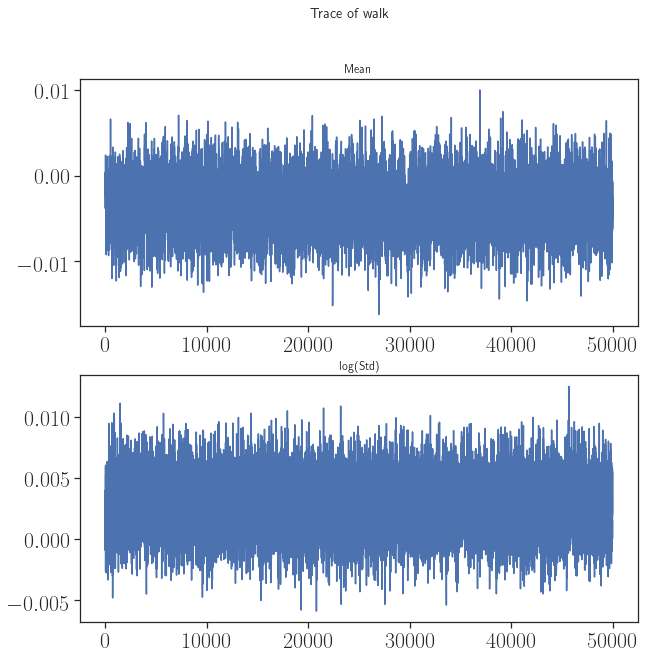

In [84]:
plot_trace(S_ref)

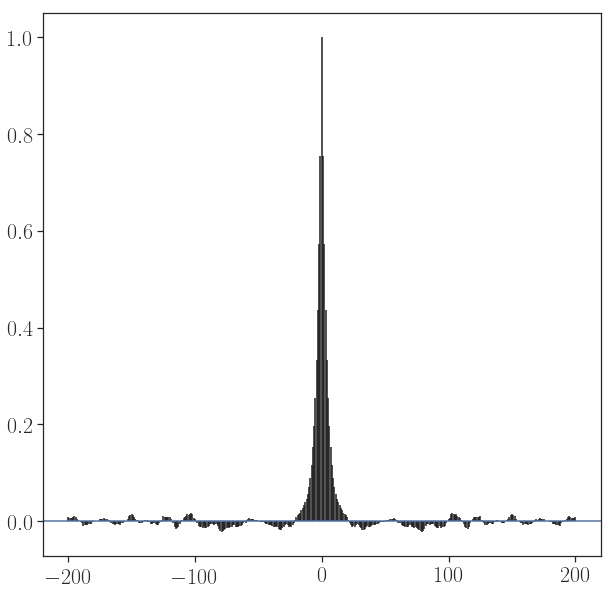

In [85]:
# Look for auto-correlation in mean and var chains
marg0 = sps.gaussian_kde(S_ref[:,0])
marg1 = sps.gaussian_kde(np.exp(S_ref[:,1]))
c = plt.acorr(np.exp(S_ref[:,1]), maxlags=200, detrend=detrend_mean, normed=True);
c_ref = c[1][c[0]>=0]
plt.show()

In [6]:
from algorithms.vanillaMH import vanillaMH
S = vanillaMH(initial_theta,x,10e6)

Iteration 0 Acceptance 1.0
Iteration 1000 Acceptance 0.5074925074925078
Iteration 2000 Acceptance 0.5007496251874064
Iteration 3000 Acceptance 0.4805064978340555
Iteration 4000 Acceptance 0.47438140464883793
Iteration 5000 Acceptance 0.46770645870825855
Iteration 6000 Acceptance 0.4687552074654226
Iteration 7000 Acceptance 0.46893300957006157
Iteration 8000 Acceptance 0.4703162104736909
Iteration 9000 Acceptance 0.4676147094767249


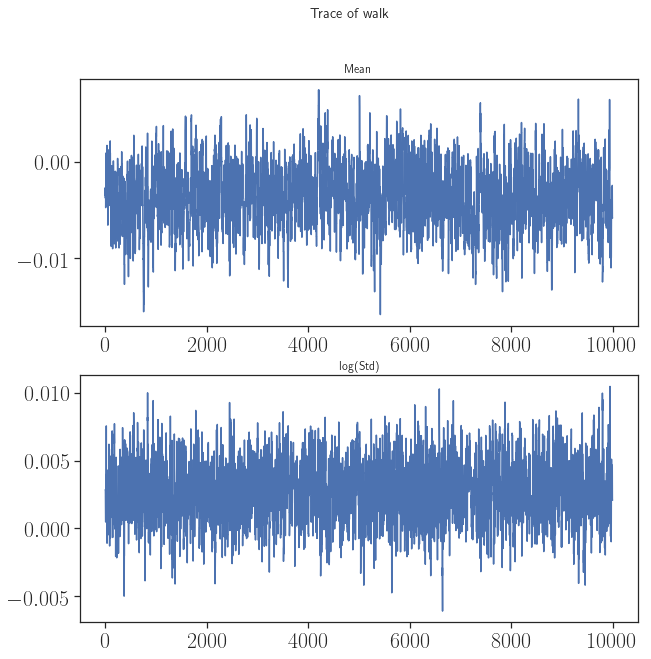

In [87]:
plot_trace(S)

xlims = -0.01624655000663229 0.010046462395395521
chain_laplace_vanillaMH_basic.pdf


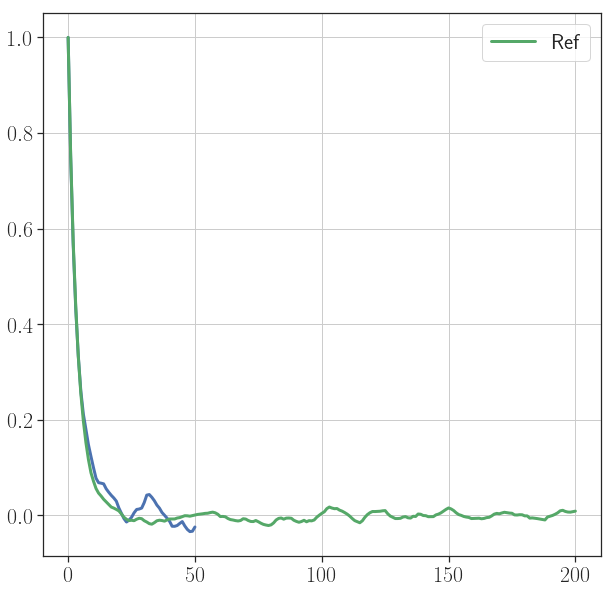

In [88]:
plotResults(S, [], algoName="vanillaMH", boolSave=1)

## ISS-MCMC

In [89]:
def sufficient_stat(samples):
    '''
    Compute a sufficient stat for our problem.
    '''
    # clearly wrong cause we dont know std but w/e
    return np.array([np.sum(samples), np.sum(samples*samples)])

In [90]:
sufficient_stat(np.array(range(5)))

array([10, 30])

In [91]:
def l2_norm_squared(vec: np.array):
    import math
    return np.sum(vec * vec)

In [92]:
def symmetric_sample_proposal(sample_indices,n,k):
    import random as ran
    out_sample = set(range(n)) - set(sample_indices)
    in_samples_leaving = ran.sample(sample_indices,k)
    out_samples_joining = ran.sample(out_sample, k)
    in_sample = set(sample_indices) - set(in_samples_leaving) | set(out_samples_joining)
    return list(in_sample)
    

In [93]:
# Sanity check for proposal function
fake_x = np.array(range(5)) * 5
print(fake_x)
sub_sample_n = 3
import random as ran
sample_indices = ran.sample(range(len(fake_x)),sub_sample_n)
print(sample_indices)
a = symmetric_sample_proposal(sample_indices,5,2)
print(a)

[ 0  5 10 15 20]
[2, 3, 0]
[1, 3, 4]


In [94]:
def ISS_MCMC(T,n,k):
    """
    perform traditional isotropic random walk Metropolis
    """
    # Discarding first value in each chain
    # Initialisation
    theta = np.array([realMean,np.log(realStd)])
    statistic_on_full_sample = sufficient_stat(x)
    # Need indices specifically for exploring the sub_samples
    import random as ran
    sub_sample_indices = ran.sample(range(len(x)),n)

    # Tuning parameters
    eps = 20 # 0 -> inf

    stepsize = .5/np.sqrt(N)
    theta_chain = np.zeros((T, 2))
    # We dont need to keep the sample chain - might be nice to keep a statistics one?
    # Suff stat here is 2D
    sample_stat_chain = np.zeros((T, 2))
    theta_acceptance = 0.0
    sample_acceptance = 0.0
    accepted_theta = 0
    accepted_samples = 0
    # Delta should really be its own fn
    scalar = len(x)/n
    
    for i in range(T):
        sub_sample = x[sub_sample_indices]
        stat_on_subsample = scalar*sufficient_stat(sub_sample)

        prop_sample_indices = symmetric_sample_proposal(sub_sample_indices,n,k)
        prop_subsample = x[prop_sample_indices]
        prop_stat_on_subsample = scalar*sufficient_stat(prop_subsample)

        current_sample_delta = statistic_on_full_sample - stat_on_subsample
        proposal_sample_delta = statistic_on_full_sample - prop_stat_on_subsample
        
        import math
        log_odds = eps*(l2_norm_squared(current_sample_delta)-l2_norm_squared(proposal_sample_delta))
        log_u = np.log(npr.rand())
        if log_u<log_odds:
            sample_stat_chain[i,:] = prop_stat_on_subsample
            sub_sample_indices = prop_sample_indices
            sub_sample = prop_subsample
            accepted_samples += 1
        else:
            sample_stat_chain[i,:] = stat_on_subsample
        
        sample_acceptance = accepted_samples/(i+1)


        thetaNew = theta
        thetaP = theta + stepsize*npr.randn(2)
        u = npr.rand()
        lhds = getLogLhd(sub_sample, thetaP[0], np.exp(thetaP[1])) - getLogLhd(sub_sample, theta[0], np.exp(theta[1]))
        Lambda = np.mean(lhds)
        psi = 1./N*np.log(u)
        if Lambda>psi:
            thetaNew = thetaP
            theta = thetaP
            accepted_theta +=1
            accepted = 1
            theta_chain[i,:] = thetaNew
        else:
            theta_chain[i,:] = theta
            
        # if i<T/10:
        #     # Perform some adaptation of the stepsize in the early iterations
        #     stepsize *= np.exp(1./(i+1)**0.6*(accepted-0.5))
        
        theta_acceptance = accepted_theta/(i+1)
        if np.mod(i,T/10)==0:
            print("Iteration", i, "Theta Acceptance", theta_acceptance, "Sample Acceptance", sample_acceptance)
            
    return (theta_chain, sample_stat_chain)

In [1]:
from algorithms.iss import iss_mcmc
iss_chain, stats = iss_mcmc(initial_theta,x) 

NameError: name 'initial_theta' is not defined

In [96]:
plot_trace(stats)

xlims = -0.01624655000663229 0.010046462395395521
chain_laplace_iss_mcmc_basic.pdf


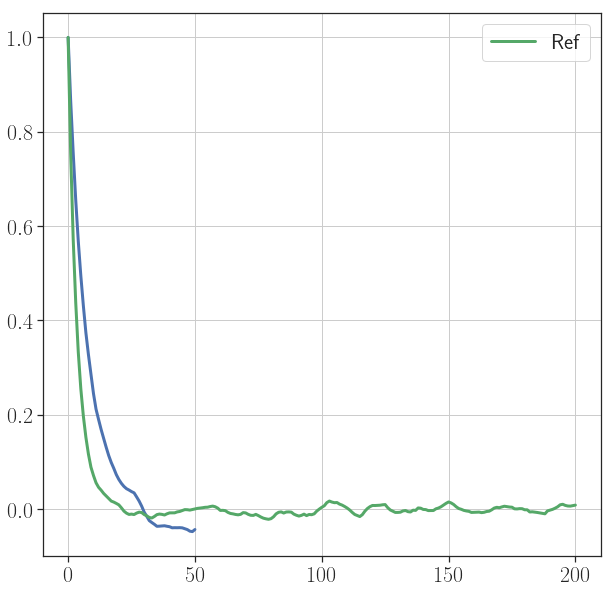

Median= nan
Plots saved


In [97]:
plotResults(ISS_S, [], algoName="iss_mcmc", boolSave=1)

## Vanilla confidence sampler

In [98]:
# Concentration bounds
def ctBernsteinSerfling(N,n,a,b,sigma,delta):
    """
    Bernstein-type bound without replacement, from (Bardenet and Maillard, to appear in Bernoulli)
    """
    l5 = np.log(5/delta)
    kappa = 7.0/3+3/np.sqrt(2)
    if n<=N/2:
        rho = 1-1.0*(n-1)/N
    else:
        rho = (1-1.0*n/N)*(1+1.0/n)
    return sigma*np.sqrt(2*rho*l5/n) + kappa*(b-a)*l5/n

def ctHoeffdingSerfling(N,n,a,b,delta):
    """
    Classical Hoeffding-type bound without replacement, from (Serfling, Annals of Stats 1974)
    """
    l2 = np.log(2/delta)
    if n<=N/2:
        rho = 1-1.0*(n-1)/N
    else:
        rho = (1-1.0*n/N)*(1+1.0/n)
    return (b-a)*np.sqrt(rho*l2/2/n)

def ctBernstein(N,n,a,b,sigma,delta):
    """
    Classical Bernstein bound, see e.g. the book by Boucheron, Lugosi, and Massart, 2014.
    """
    l3 = np.log(3/delta)
    return sigma*np.sqrt(2*l3/n) + 3*(b-a)*l3/n

In [99]:
# Confidence MCMC (Bardenet, Doucet, and Holmes, ICML'14)

def confidenceMCMC(T):
    
    # Initialize
    theta = np.array([realMean,np.log(realStd)])
    stepsize = .01 
    S_B = np.zeros((T,2))
    delta = .1
    acceptance = 0.0
    gamma = 1.5
    ns_B = []
    
    for i in range(T):
        
        npr.shuffle(x)
        accepted = 0
        done = 0
        thetaNew = theta
        thetaP = theta + stepsize*npr.randn(2)
        u = npr.rand()
        n = N/10
        cpt = 0
        lhds = getLogLhd(x, thetaP[0], np.exp(thetaP[1])) - getLogLhd(x, theta[0], np.exp(theta[1]))
        a = np.min(lhds)
        b = np.max(lhds)
            
        while not done and n<N:
        
            n = int(min(N,np.floor(gamma*n)))
            cpt+=1
            deltaP = delta/2/cpt**2
            # The following step should be done differently to avoid recomputing previous likelihoods, but for the toy examples we keep it short
            lhds = getLogLhd(x[:n], thetaP[0], np.exp(thetaP[1])) - getLogLhd(x[:n], theta[0], np.exp(theta[1])) 
            Lambda = np.mean(lhds)
            sigma = np.std(lhds)
            psi = np.log(u)/N
            if np.abs(Lambda-psi) > ctBernstein(N,n,a,b,sigma,deltaP):
                done = 1
        
        if i>1 and ns_B[-1] == 2*N:
            ns_B.append(n) # Half of the likelihoods were computed at the previous stage
        else:
            ns_B.append(2*n) # The algorithm required all likelihoods for theta and theta', next iteration we can reuse half of them
        
        if Lambda>psi:
            # Accept
            theta = thetaP
            accepted = 1
            S_B[i] = thetaP
        else:
            # Reject
            S_B[i] = theta
            
        if i<T/10:
            # Perform some adaptation of the stepsize in the early iterations
            stepsize *= np.exp(1./(i+1)**0.6*(accepted-0.5))    
            
        acceptance*=i
        acceptance+=accepted
        acceptance/=(i+1)
        if np.mod(i,T/10)==0:
            # Monitor acceptance and average number of samples used
            print("Iteration", i, "Acceptance", acceptance, "Avg. num evals", np.mean(ns_B), "sigma/sqrt(n)", sigma/np.sqrt(n), "R/n", (b-a)/n)
        
    return S_B, ns_B

In [100]:
S_B, ns_B = confidenceMCMC(10000)

Iteration 0 Acceptance 0.0 Avg. num evals 200000.0 sigma/sqrt(n) 8.433011140409695e-05 R/n 6.904351967273285e-06
Iteration 1000 Acceptance 0.49050949050949044 Avg. num evals 149711.84915084916 sigma/sqrt(n) 1.2722722274285394e-05 R/n 1.0147936902836501e-06
Iteration 2000 Acceptance 0.5212393803098446 Avg. num evals 149325.95952023988 sigma/sqrt(n) 5.116005616011087e-06 R/n 3.889628781997212e-07
Iteration 3000 Acceptance 0.5268243918693764 Avg. num evals 149071.86871042984 sigma/sqrt(n) 1.9301366426992973e-05 R/n 1.6421113287609034e-06
Iteration 4000 Acceptance 0.529617595601099 Avg. num evals 149110.6880779805 sigma/sqrt(n) 4.357767868271404e-05 R/n 3.7970708881191118e-06
Iteration 5000 Acceptance 0.5360927814437118 Avg. num evals 149062.80923815237 sigma/sqrt(n) 1.4085124307420556e-05 R/n 1.228123479515487e-06
Iteration 6000 Acceptance 0.5392434594234303 Avg. num evals 149084.94034327613 sigma/sqrt(n) 2.2811569626159178e-05 R/n 1.9861811743687933e-06
Iteration 7000 Acceptance 0.542779

xlims = -0.01624655000663229 0.010046462395395521
chain_laplace_vanillaConfidence_basic.pdf


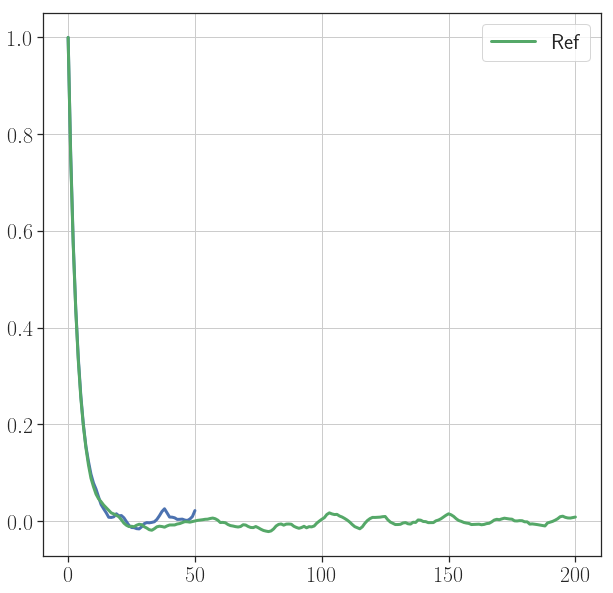

Median= 101250.0
Plots saved


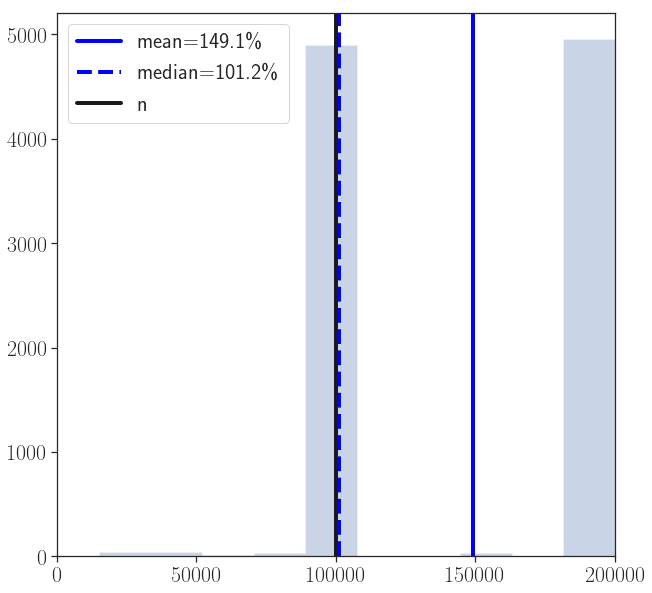

In [101]:
plotResults(S_B, ns_B, boolSave=1, algoName="vanillaConfidence")

## Confidence MH with 2nd order Taylor likelihood proxy

In [102]:
def combineMeansAndSSQs(N1, mu1, ssq1, N2, mu2, ssq2):
    """
    combine means and sum of squares of two sets
    """
    dd = mu2 - mu1
    mu = mu1
    ssq = ssq1
    N = N1+N2
    mu += dd*N2/N
    ssq += ssq2
    ssq += (dd**2) * N1 * N2 / N
    return N, mu, ssq

In [103]:
# Differential functions for proxies, 

# Define vectorized evaluation of gradient and Hessian
myGradientVect = lambda x_float, mu_float, sigma_float:np.array([-(2*mu_float - 2*x_float)/(2*sigma_float**2), -1/sigma_float + (-mu_float + x_float)**2/sigma_float**3]).T
myHessianVect = lambda x_float, mu_float, sigma_float:[[-1/sigma_float**2*np.ones(x_float.shape), 2*(mu_float - x_float)/sigma_float**3], [2*(mu_float - x_float)/sigma_float**3, (1 - 3*(mu_float - x_float)**2/sigma_float**2)/sigma_float**2]]

# Compute third order derivatives to bound the Taylor remainder. Symbolic differentiation is not really necessary in this simple case, but
# it may be useful in later applications
def thirdDerivatives():
    x, mu, sigma = sym.symbols('x, mu, sigma')
    L = []
    for i in range(4):
        for j in range(4):
            if i+j == 3:
                args = tuple([-(x-mu)**2/(2*sigma**2) -sym.log(sigma)] + [mu for cpt in range(i)] + [sigma for cpt in range(j)])                
                L.append( sym.diff(*args) )
    return L
    
def evalThirdDerivatives(x_float, mu_float, logSigma_float): 
    tt = thirdDerivatives()
    return [tt[i].subs('x',x_float).subs('mu',mu_float).subs('sigma',np.exp(logSigma_float)).evalf() for i in range(4)]

# Find the MAP (not really necessary here since the MAP are the mean and std deviation of the data)
f = lambda theta: -np.mean(getLogLhd(x, theta[0], np.exp(theta[1])))
thetaMAP = spo.minimize(f, np.array([realMean, np.log(realStd)])).x
print("MAP is", thetaMAP, "Real values are", realMean, np.log(realStd))
tt = thirdDerivatives()
print(tt)

MAP is [-0.00348284  0.00284442] Real values are -0.003482840286949395 0.0028444213485638763
[2*(-1 + 6*(mu - x)**2/sigma**2)/sigma**3, -6*(mu - x)/sigma**4, 2/sigma**3, 0]


We will need to bound the absolute value of the third derivatives.

In [104]:
tt = thirdDerivatives()
print(tt)

[2*(-1 + 6*(mu - x)**2/sigma**2)/sigma**3, -6*(mu - x)/sigma**4, 2/sigma**3, 0]


To apply the two Taylor expansions, it is enough to bound them on the union of the two segments 
$$\{(1-t)\theta^\star+t\theta, t\in[0,1]\}\cup\{(1-t)\theta^\star+t\theta', t\in[0,1]\},$$
where $\theta=(\mu,\sigma)$. Given their form, it is enough to bound them by taking the max of their absolute values when $\vert x-\mu\vert$ is maximal and $\sigma$ minimal in this union. Since the code is a bit hard to read, we have added a simple check of the bound in the algorithm to convince the reader the bound is correct.

In [105]:
# Confidence MCMC with proxy (Bardenet, Doucet, and Holmes, this submission)
def confidenceMCMCWithProxy(T):
    
    npr.seed(1)
    # Initialize
    theta = np.array([realMean,np.log(realStd)])
    stepsize = .01 
    S_B = np.zeros((T,2))
    delta = .1
    acceptance = 0.0
    gamma = 2.
    ns_B = []
    
    # Compute some statistics of the data that will be useful for bounding the error and averaging the proxies    
    minx = np.min(x)
    maxx = np.max(x)
    meanx = np.mean(x)
    meanxSquared = np.mean(x**2)
    
    # Prepare total sum of Taylor proxys
    muMAP = thetaMAP[0]
    sigmaMAP = np.exp(thetaMAP[1])
    meanGradMAP = np.array( [(meanx - muMAP)/sigmaMAP**2, (meanxSquared-2*muMAP*meanx+muMAP**2)/sigmaMAP**3 - 1./sigmaMAP] )
    meanHessMAP = np.array( [[-1./sigmaMAP**2, -2*(meanx-muMAP)/sigmaMAP**3], [-2*(meanx-muMAP)/sigmaMAP**3, -3*(meanxSquared-2*muMAP*meanx+muMAP**2)/sigmaMAP**4 + 1/sigmaMAP**2]] )    
    
    for i in range(T):
        
        npr.shuffle(x)
        accepted = 0
        done = 0
        thetaNew = theta
        thetaP = theta + stepsize*npr.randn(2)
        u = npr.rand()
        n = 2
        t0 = 0
        cpt = 0
        Lambda = 0
        ssq = 0 # Sum of squares
        
        # Prepare Taylor bounds
        xMinusMuMax = np.max(np.abs([1, minx-theta[0], maxx-theta[0], minx-thetaMAP[0], maxx-thetaMAP[0], minx-thetaP[0], maxx-thetaP[0]]))
        sigmaMin = np.min(np.exp([theta[1], thetaMAP[1], thetaP[1]]))
        R = float(np.max(np.abs(evalThirdDerivatives(xMinusMuMax, 0, np.log(sigmaMin)))))
        h = np.array([theta[0]-thetaMAP[0], np.exp(theta[1])-np.exp(thetaMAP[1])])
        hP = np.array([thetaP[0]-thetaMAP[0], np.exp(thetaP[1])-np.exp(thetaMAP[1])])
        R *= 2*1./6 * max(np.sum(np.abs(h)), np.sum(np.abs(hP)))**3
        a = -R
        b = R
        
        # We can already compute the average proxy log likelihood ratio
        avgTotalProxy = np.dot(meanGradMAP, hP-h) + .5*np.dot( hP-h, np.dot(meanHessMAP, h+hP) ) 
        
        while not done and n<N:
        
            n = int(min(N,np.floor(gamma*n)))
            cpt+=1
            deltaP = delta/2/cpt**2
            batch = x[t0:n]
            lhds = getLogLhd(batch, thetaP[0], np.exp(thetaP[1])) - getLogLhd(batch, theta[0], np.exp(theta[1]))
            proxys = np.dot(myGradientVect(batch, muMAP, sigmaMAP), hP-h) + 0.5*np.dot(np.dot(hP-h, myHessianVect(batch,muMAP,sigmaMAP)).T, h+hP)
            if np.any(np.abs(lhds-proxys)>R):
                # Just a check that our error is correctly bounded
                print("Taylor remainder is underestimated")
            tmp, Lambda, ssq = combineMeansAndSSQs(t0, Lambda, ssq, n-t0, np.mean(lhds-proxys), (n-t0)*np.var(lhds-proxys))
            sigma = np.sqrt(1./n*ssq)
            psi = np.log(u)/N
            t0 = n
            if np.abs(Lambda-psi + avgTotalProxy) > ctBernstein(N,n,a,b,sigma,deltaP):
                done = 1
        
        if i>1 and ns_B[-1] == 2*N:
            ns_B.append(n) # Half of the likelihoods were computed at the previous stage
        else:
            ns_B.append(2*n)
            
        if Lambda+avgTotalProxy>psi:
            # Accept
            theta = thetaP
            accepted = 1
            S_B[i] = thetaP
        else:
            # Reject
            S_B[i] = theta
            
        if i<T/10:
            # Perform some adaptation of the stepsize in the early iterations
            stepsize *= np.exp(1./(i+1)**0.6*(accepted-0.5))    
        
        acceptance*=i
        acceptance+=accepted
        acceptance/=(i+1)
        if np.mod(i,T/10)==0:
            # Monitor acceptance and average number of samples used
            print("Iteration", i, "Acceptance", acceptance, "Avg. num samples", np.mean(ns_B), "Dist. to MAP", np.sum( np.abs(theta-thetaMAP) ), "sigma/sqrt(n)", sigma/np.sqrt(n), "R/n", R/n)
        
    return S_B, ns_B

In [106]:
S_BP, ns_BP = confidenceMCMCWithProxy(10000)

Iteration 0 Acceptance 0.0 Avg. num samples 4096.0 Dist. to MAP 0.0 sigma/sqrt(n) 1.4494878535269725e-09 R/n 5.019813977802555e-08
Iteration 1000 Acceptance 0.4985014985014985 Avg. num samples 3030.5854145854146 Dist. to MAP 0.00339384759948184 sigma/sqrt(n) 1.6670498697697004e-10 R/n 2.8386897895586727e-07
Iteration 2000 Acceptance 0.49475262368815603 Avg. num samples 2973.28135932034 Dist. to MAP 0.0034728945904066773 sigma/sqrt(n) 1.5790449019870327e-09 R/n 3.841593898195966e-07
Iteration 3000 Acceptance 0.49250249916694444 Avg. num samples 3183.2189270243252 Dist. to MAP 0.010834478873129622 sigma/sqrt(n) 4.984021201169618e-08 R/n 2.8345030956956885e-07
Iteration 4000 Acceptance 0.4858785303674082 Avg. num samples 3129.0497375656087 Dist. to MAP 0.003480539585183233 sigma/sqrt(n) 1.7529604257722448e-08 R/n 1.528340398701448e-07
Iteration 5000 Acceptance 0.488902219556089 Avg. num samples 3150.985802839432 Dist. to MAP 0.002607635353775189 sigma/sqrt(n) 3.39434473035379e-08 R/n 2.32

In [ ]:
plotResults(S_BP, ns_BP, algoName="confidenceProxy", boolSave=1)

## Confidence MCMC with proxys dropped along the way

This is a version of the confidence sampler with proxy that drops a proxy every 20 iterations.

In [109]:
def dropProxy(thetaStar, meanx, minx, maxx, meanxSquared):
    """
    compute all quantities necessary to the evaluation of a proxy at thetaStar
    """
    muStar = thetaStar[0]
    sigmaStar = np.exp(thetaStar[1])
    meanGradStar = np.array( [(meanx - muStar)/sigmaStar**2, (meanxSquared-2*muStar*meanx+muStar**2)/sigmaStar**3 - 1./sigmaStar] )
    meanHessStar = np.array( [[-1./sigmaStar**2, -2*(meanx-muStar)/sigmaStar**3], [-2*(meanx-muStar)/sigmaStar**3, -3*(meanxSquared-2*muStar*meanx+muStar**2)/sigmaStar**4 + 1/sigmaStar**2]] )    
    return meanGradStar, meanHessStar

def confidenceMCMCWithProxyDroppedAlong(T):
    """
    perform confidence MCMC with proxy dropped every 20 iterations
    """
    npr.seed(1)
    # Initialize
    theta = np.array([realMean,np.log(realStd)])
    stepsize = .1 
    S_B = np.zeros((T,2))
    delta = .1
    acceptance = 0.0
    gamma = 2.
    ns_B = []
    
    # Compute min and max of data    
    minx = np.min(x)
    maxx = np.max(x)
    meanx = np.mean(x)
    meanxSquared = np.mean(x**2)
    
    # Prepare Taylor proxys
    thetaStar = thetaMAP
    muStar = thetaStar[0]
    sigmaStar = np.exp(thetaStar[1])
    meanGradStar, meanHessStar = dropProxy(thetaStar, meanx, minx, maxx, meanxSquared)
    
    for i in range(T):
        
        npr.shuffle(x)
        accepted = 0
        done = 0
        thetaNew = theta
        thetaP = theta + stepsize*npr.randn(2)
        u = npr.rand()
        n = 2
        t0 = 0
        cpt = 0
        Lambda = 0
        ssq = 0
        
        # Prepare Taylor bounds
        xMinusMuMax = np.max(np.abs([1, minx-theta[0], maxx-theta[0], minx-thetaStar[0], maxx-thetaStar[0], minx-thetaP[0], maxx-thetaP[0]]))
        sigmaMin = np.min(np.exp([theta[1], thetaStar[1], thetaP[1]]))
        R = float(np.max(np.abs(evalThirdDerivatives(xMinusMuMax, 0, np.log(sigmaMin)))))
        h = np.array([theta[0]-thetaStar[0], np.exp(theta[1])-np.exp(thetaStar[1])])
        hP = np.array([thetaP[0]-thetaStar[0], np.exp(thetaP[1])-np.exp(thetaStar[1])])
        R *= 2*1./6 * max(np.sum(np.abs(h)), np.sum(np.abs(hP)))**3
        a = -R
        b = R
        
        avgTotalProxy = np.dot(meanGradStar, hP-h) + .5*np.dot( hP-h, np.dot(meanHessStar, h+hP) ) 
        
        while not done and n<N:
        
            n = int(min(N,np.floor(gamma*n)))
            
            if not np.mod(i,20): # Loop over whole dataset and recompute proxys when finished
                n = N
            
            cpt+=1
            deltaP = delta/2/cpt**2
            batch = x[t0:n]
            lhds = getLogLhd(batch, thetaP[0], np.exp(thetaP[1])) - getLogLhd(batch, theta[0], np.exp(theta[1]))
            proxys = np.dot(myGradientVect(batch, muStar, sigmaStar), hP-h) + 0.5*np.dot(np.dot(hP-h, myHessianVect(batch,muStar,sigmaStar)).T, h+hP)
            if np.any(np.abs(lhds-proxys)>R):
                print("Taylor remainder is underestimated")
            tmp, Lambda, ssq = combineMeansAndSSQs(t0, Lambda, ssq, n-t0, np.mean(lhds-proxys), (n-t0)*np.var(lhds-proxys))
            sigma = np.sqrt(1./n*ssq)
            psi = np.log(u)/N
            t0 = n
            #print "n, abs(L-psi), bound, sigma/sqrt(n), R/n", n, np.abs(Lambda-psi), ctBernstein(N,n,a,b,sigma,deltaP), sigma/np.sqrt(n), R/n
            if np.abs(Lambda-psi + avgTotalProxy) > ctBernstein(N,n,a,b,sigma,deltaP):
                done = 1
        
        if i>1 and ns_B[-1] == 2*N:
            ns_B.append(n) # Half of the likelihoods were computed at the previous stage
        else:
            ns_B.append(2*n)
            
        if not np.mod(i,20): # Recompute proxys every 20 iterations
            thetaStar = theta
            muStar = thetaStar[0]
            sigmaStar = np.exp(thetaStar[1])
            meanGradStar, meanHessStar = dropProxy(thetaStar, meanx, minx, maxx, meanxSquared)
                
        if Lambda+avgTotalProxy>psi:
            # Accept
            theta = thetaP
            accepted = 1
            S_B[i] = thetaP
        else:
            # Reject
            S_B[i] = theta
            
            
        if i<T/10:
            # Perform some adaptation of the stepsize in the early iterations
            stepsize *= np.exp(1./(i+1)**0.6*(accepted-0.5))    
        
        acceptance*=i
        acceptance+=accepted
        acceptance/=(i+1)
        if np.mod(i,T/10)==0:
            # Monitor acceptance and average number of samples used
            print("Iteration", i, "Acceptance", acceptance, "Avg. num samples", np.mean(ns_B), "Dist. to MAP", np.sum( np.abs(theta-thetaMAP) ), "sigma/sqrt(n)", sigma/np.sqrt(n), "R/n", R/n)
        
    return S_B, ns_B

In [110]:
S_BPD, ns_BPD = confidenceMCMCWithProxyDroppedAlong(10000)

Iteration 0 Acceptance 0.0 Avg. num samples 200000.0 Dist. to MAP 0.0 sigma/sqrt(n) 2.3182317123238477e-07 R/n 1.1304690117292515e-06
Iteration 1000 Acceptance 0.48451548451548465 Avg. num samples 14667.076923076924 Dist. to MAP 0.0009831291129169311 sigma/sqrt(n) 8.62924225534225e-11 R/n 1.9952233963924914e-10
Iteration 2000 Acceptance 0.5007496251874055 Avg. num samples 15303.240379810095 Dist. to MAP 0.0015839295066502942 sigma/sqrt(n) 3.764724300816191e-10 R/n 3.8924736188204047e-10
Iteration 3000 Acceptance 0.5028323892035987 Avg. num samples 15245.53948683772 Dist. to MAP 0.007857185270510915 sigma/sqrt(n) 4.995960496769538e-09 R/n 4.879172627496236e-09
Iteration 4000 Acceptance 0.5003749062734308 Avg. num samples 14915.964008997751 Dist. to MAP 0.0033609741287777004 sigma/sqrt(n) 1.7563841932121948e-09 R/n 4.824782560607609e-10
Iteration 5000 Acceptance 0.5026994601079782 Avg. num samples 15023.929614077184 Dist. to MAP 0.0026687033755141546 sigma/sqrt(n) 1.9019605479423027e-09 

xlims = -0.01624655000663229 0.010046462395395521
chain_laplace_doesNotMatter_basic.pdf


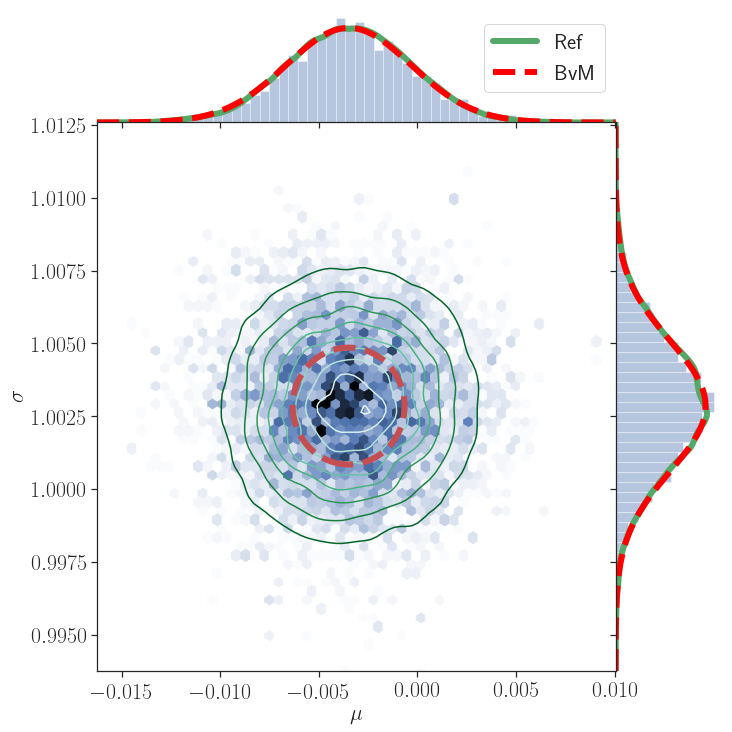

Median= 1024.0


In [111]:
plotResults(S_BPD, ns_BPD)